# Counting Pixels from R-1 Imagery

**Disclaimer: Currently the R-1 lake segmentation is not part of the pipeline!!! This means that the images are too noisy to be compared and conclusions drawn are fairly insignificant.**

## 1. Setup

In [46]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from osgeo import gdal, gdal_array
from pathlib import Path
import os
import fnmatch
import random

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

## 2. Function to Open Images and Return Histogram of Pixel Values

In [47]:
def image_to_array(location_string):
    img_ds = gdal.Open(location_string, gdal.GA_ReadOnly)
    band = img_ds.GetRasterBand(1)
    img = band.ReadAsArray()
    return img

In [48]:
def image_to_linear_array(location_string, increment):
    matrix = image_to_array(location_string)
    if (sum(sum(matrix))) > 10000000:
        temp = np.hstack(matrix)//255    
        return np.histogram(temp, bins=np.arange(start=0, stop=256, step=increment))
    return np.histogram(np.hstack(matrix), bins=np.arange(start=0, stop=256, step=increment))

In [49]:
full_ice = []
for root, dirnames, filenames in os.walk('100Percent'):
    for filename in fnmatch.filter(filenames, '*.tif'):
        full_ice.append(os.path.join(root, filename))
no_ice = []
for root, dirnames, filenames in os.walk('0Percent'):
    for filename in fnmatch.filter(filenames, '*.tif'):
        no_ice.append(os.path.join(root, filename))

In [50]:
INCREMENT = 8
bins = 0
arrays_100 = []
arrays_0 = []

for file in full_ice:
    linarr, bins = image_to_linear_array(file, INCREMENT)
    arrays_100.append(linarr)
for file in no_ice:
    linarr, bins = image_to_linear_array(file, INCREMENT)
    arrays_0.append(linarr)
print(len(arrays_100), len(arrays_0), bins)

17 37 [  0   8  16  24  32  40  48  56  64  72  80  88  96 104 112 120 128 136
 144 152 160 168 176 184 192 200 208 216 224 232 240 248]


In [62]:
total_100_linarr = [0]*(len(bins)-1)
for array in arrays_100:
    total_100_linarr = np.add(total_100_linarr, array)
total_0_linarr = [0]*(len(bins)-1)
# Random sampling 17 files as there are only 17 valid 100% ICE_COVER files, so remaining consistent with 0% ICE_COVER files.
for array in random.sample(arrays_0, 17):
    total_0_linarr = np.add(total_0_linarr, array)

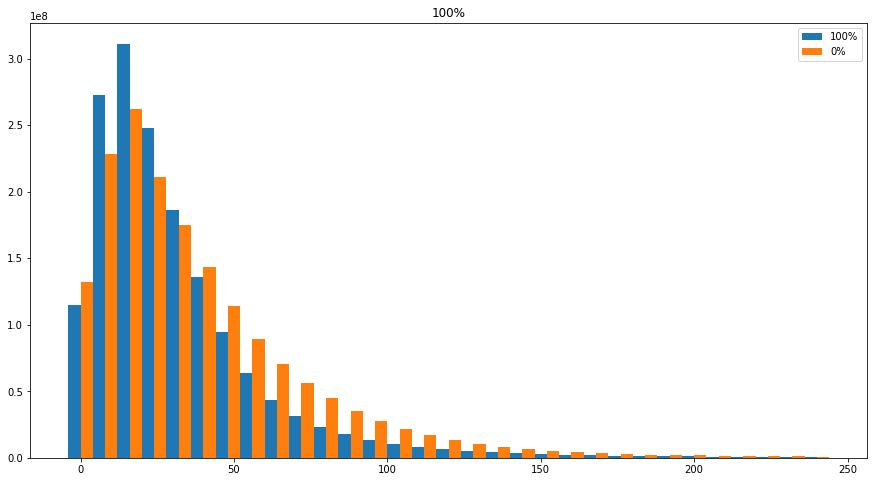

In [52]:
fig, ax1 = plt.subplots(1, 1)
fig.set_figheight(8)
fig.set_figwidth(15)
width = 4
rects1 = ax1.bar(height=total_100_linarr, x=bins[:-1]-width/2, width=width, label="100%")
ax1.set_title('100%')
rects2 = ax1.bar(height=total_0_linarr, x=bins[:-1]+width/2, width=width, label="0%")
ax1.legend()

## 4. Creating a DataFrame of the Histograms

In [53]:
df_100 = pd.DataFrame(arrays_100)
df_0 = pd.DataFrame(random.sample(arrays_0, 17))

<AxesSubplot:>

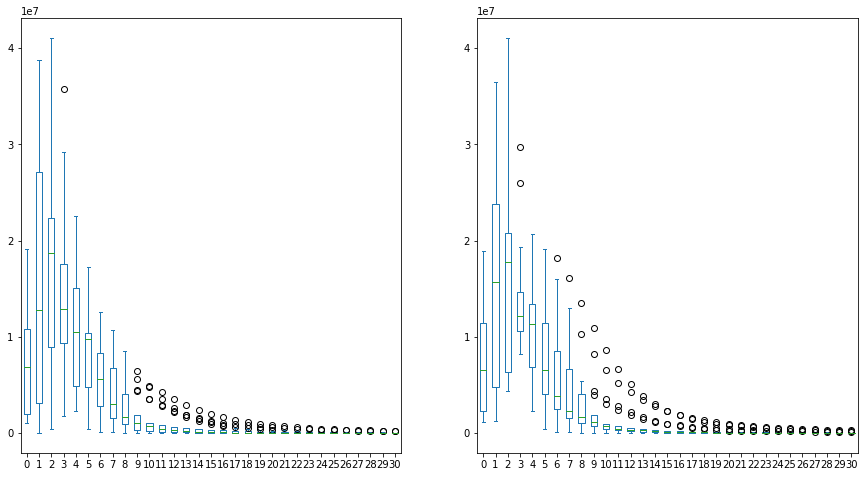

In [54]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)
ax100 = df_100.plot(kind="box", ax=ax1)
df_0.plot(kind="box", ylim = ax1.get_ylim(), ax=ax2)

## 5. Sample Machine Learning Algorithm

In [56]:
df_0['ICE'] = 0
df_100['ICE'] = 1
df_all = pd.concat([df_100, df_0])

In [57]:
import sklearn as sk
from sklearn import svm
import pickle

In [58]:
y = df_all.iloc[:,31]
X = df_all.iloc[:,:31]

In [59]:
SVM = svm.SVC()
SVM.fit(X, y)

SVC()

In [60]:
filename = 'finalized_model.sav'
pickle.dump(SVM, open(filename, 'wb'))

In [61]:
round(SVM.score(X,y), 4)

0.7059